## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are their assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [357]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
import seaborn as sns #plt.style.use(“seaborn”)
%matplotlib inline
#from statsmodels.iolib.summary2 import summary_col
#summary_col([reg0,reg1,reg2,reg3,reg4])
#from pandas.core import datetools
#pandas.tseries module

My goal is to create a model that predicts housing prices well even outside of sample.  First I'll read in the train and test data.

In [358]:
train=pd.read_csv('train.csv')
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [359]:
test=pd.read_csv('test.csv')
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


I notice that SalePrice is not included in the Kaggle Testing set.  I need to split off a subset of my training set so I can test how accurate my models' predictions for Sale Price are.

In [360]:
X_train, X_test, y_train, y_test = train_test_split(train, train['SalePrice'], test_size=.20, random_state=42)

Here y-train is my target and I will begin by cleaning X_train.  I will isolate the variables for which over 50% of the observations are grouped in one category.  I classify these variables as dropped and will not include them in my  models.

In [361]:
dropped = []
for i in X_train:
   if X_train[i].dtype == 'object':
       if X_train[i].value_counts(normalize=True, dropna= False).iloc[0] > .5:
            #print (train[i].value_counts(normalize=True))
            dropped.append(i)

From the documentation provided by Kaggle, I can see that Central Air is a binary variable for whether or not the home has air conditioning.  I don't actually want to drop this because it might be a good indicator of home value and almost certainly more than 50% of homes into either the yes or no category.

In [362]:
dropped.remove('CentralAir')

I'm also going to put the dropped array into a format that is easier to work with later. 

In [363]:
dropped=X_train[['Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']]

I carefully look through the documentation and make some determinations about the categorigal and quantitative variables I have to work with.  There are many categorical variables I can productively convert to dummy variables and a few I may be able to convert to meaningful quantitative variables.  Some qualitative variables such as OverallQual follow a Likert scale and already make sense as quantitatve variables.  I will start by converting MSZoning, Utilities, Neighborhood, RoofStyle, RoofMatl, Exterior1st, BsmtFinType1, FireplaceQu into dummy variables. 

MS Subclass- group by # of stories

Include- LotFrontage, LotArea, OverallQual, OverallCond, MasVnrArea, Foundation, BsmtQual, BasFinSF1,TotalBsmtSF, Fireplaces, CentralAir, FullBath, HalfBath, Bedroom, Kitchen, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold, YearBuilt, YearRemodAdd

Make Quantitative- HouseStyle

In [364]:
X_train=pd.get_dummies(X_train, columns=['MSZoning','Utilities','Neighborhood','RoofStyle',
                                   'RoofMatl','Exterior1st', 'BsmtFinType1','FireplaceQu','PavedDrive','Foundation',
                                     'CentralAir'], 
               prefix=['Zone','Utilities','Neighborhood','RoofStyle','RoofMatl','Exterior','BsmtFinish','FireplaceQu',
                       'Paving','Foundation','CentralAir'])
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,Paving_P,Paving_Y,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y
254,255,20,70.0,8400,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,1,0,1,0,0,0,0,0,1
1066,1067,60,59.0,7837,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,1,0,0,1,0,0,0,0,1
638,639,30,67.0,8777,Pave,NaN,Reg,Lvl,Inside,Gtl,...,1,0,0,1,0,0,0,0,0,1
799,800,50,60.0,7200,Pave,NaN,Reg,Lvl,Corner,Gtl,...,0,1,1,0,0,0,0,0,0,1
380,381,50,50.0,5000,Pave,Pave,Reg,Lvl,Inside,Gtl,...,0,1,1,0,0,0,0,0,0,1


A quick check to see if this worked properly:

In [365]:
X_train.BsmtFinish_Rec.value_counts(dropna=False)

0    1064
1     104
Name: BsmtFinish_Rec, dtype: int64

Good!  Now I can take a look at making some of our other categorical variables quantitative.

In [366]:
X_train.HouseStyle.value_counts(dropna=False)

1Story    577
2Story    360
1.5Fin    121
SLvl       52
SFoyer     28
1.5Unf     12
2.5Unf     11
2.5Fin      7
Name: HouseStyle, dtype: int64

The most meaningful information I draw from this variable is the number of stories in each home.  Nowhere in our data is this included as its own variable so I will take the opportunity to convert HouseStyle into a quantitative variable that will serve this purpose.  Note that the value counts in the unfinished categories are small.  I will pool these together with their finished counterparts.

In [367]:
X_train['HouseStyle'] = X_train['HouseStyle'].map({'1Story': 1, '1.5Unf': 1.5, '1.5Fin':1.5, '2Story':2,'SFoyer':2,
                                              '2.5Unf':2.5,'2.5Fin':2.5, 'SLvl':2.5})

Here I classify Split-Foyer homes in the same quantitative category as two story homes because they are typically designed with a set of downward stairs and upwards stairs that lead out of the small foyer area into the two main levels of the home.  I likewise classify Split Level Homes (often called "Tri-Level" homes) in the same category as finished 2.5 story homes because they are often three levels with one level significantly smaller than the other two.

Let's see how this looks.

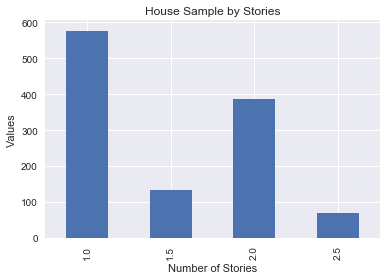

In [368]:
X_train['HouseStyle'].value_counts().sort_index().plot(kind='bar',x=[1,1.5,2.0,2.5])
plt.title('House Sample by Stories')
#plt.xticks([1,1.5,2.0,2.5])
plt.ylabel('Values')
plt.xlabel('Number of Stories')

Let's take a look at another variable I considered including.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

Many of these categories communicate information about number of stories, which we have already reflected in our HouseStyle variable.  There is also some component of home age communicated in this data but only in broad distinctions (Pre and Post 1945) and this is not consistent across all categories.  For this reason, I will decline to include this variable in my models.

Let's take a look at BsmtQual--

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

In [369]:
X_train.BsmtQual.value_counts(dropna=False)

TA     521
Gd     493
Ex      97
Fa      29
NaN     28
Name: BsmtQual, dtype: int64

I intially considered converting this variable into dummies but because there are no houses in the poor category (in which a house could in theory be anywhere from 1 inch to 69 inches) I think it is reasonable to make this variable quantitative by mapping each category into its minimum height.  I will still create a mapping for poor in case a home outside our train sample has a poor basement, but I don't suspect it will be very common.  Less than 6 feet of basement height is pretty awful.

In [370]:
X_train['BsmtQual'] = X_train['BsmtQual'].map({'Po':60, 'Fa':70, 'TA':80, 'Gd':90,'Ex':100})

In [371]:
X_train['BsmtQual']=X_train['BsmtQual'].fillna(0)

In [372]:
X_train['BsmtQual'].value_counts()

80.0     521
90.0     493
100.0     97
70.0      29
0.0       28
Name: BsmtQual, dtype: int64

Now that I've categorized my variables how I like, let's handle missing values.

In [373]:
#train.isnull().any()
X_train.columns[X_train.isnull().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

After cross-checking this list with the list of variables I decided to drop from my regression, I determined that I need to handle missing values for LotFrontage, MasVnrArea, GarageYrBlt, GarageFinish, and BsmtQual.  Taking a glance at the value_counts I decide filling GarageFinish and BsmtQual with the mode and the rest with the mean is reasonable.

In [374]:
X_train['GarageFinish']=X_train['GarageFinish'].fillna(X_train['GarageFinish'].mode())
X_train['LotFrontage']=X_train['LotFrontage'].fillna(X_train['LotFrontage'].mean())
X_train['MasVnrArea']=X_train['MasVnrArea'].fillna(X_train['MasVnrArea'].mean())
X_train['GarageYrBlt']=X_train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mean())

In [376]:
X_train['GarageFinish'].value_counts()

Unf    480
RFn    339
Fin    285
Name: GarageFinish, dtype: int64

In [377]:
X_train=pd.get_dummies(X_train, columns=['GarageFinish'])

In [378]:
X_train['GarageFinish_Unf'].value_counts()

0    688
1    480
Name: GarageFinish_Unf, dtype: int64

Let's check that this cleared up our missing values.

In [379]:
X_train['LotFrontage'].isnull().head(20)

254     False
1066    False
638     False
799     False
380     False
303     False
86      False
1385    False
265     False
793     False
1445    False
808     False
1099    False
605     False
701     False
221     False
113     False
548     False
1073    False
174     False
Name: LotFrontage, dtype: bool

In [380]:
#train.isnull().any()
X_train.columns[X_train.isnull().any()].tolist()

['Alley',
 'MasVnrType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [381]:
X_train=X_train.drop(dropped,axis=1)

In [382]:
X_train.dtypes

Id                     int64
MSSubClass             int64
LotFrontage          float64
LotArea                int64
HouseStyle           float64
OverallQual            int64
OverallCond            int64
YearBuilt              int64
YearRemodAdd           int64
Exterior2nd           object
MasVnrArea           float64
BsmtQual             float64
BsmtFinSF1             int64
BsmtFinSF2             int64
BsmtUnfSF              int64
TotalBsmtSF            int64
1stFlrSF               int64
2ndFlrSF               int64
LowQualFinSF           int64
GrLivArea              int64
BsmtFullBath           int64
BsmtHalfBath           int64
FullBath               int64
HalfBath               int64
BedroomAbvGr           int64
KitchenAbvGr           int64
TotRmsAbvGrd           int64
Fireplaces             int64
GarageYrBlt          float64
GarageCars             int64
                      ...   
Exterior_Stone         uint8
Exterior_Stucco        uint8
Exterior_VinylSd       uint8
Exterior_Wd Sd

Exterior2nd is still an object and probably not a huge driver of home value so I'm going to drop it from my data frame.

In [394]:
X_train=X_train.drop(['Exterior2nd'],axis=1)

In [395]:
#Ok to do after cleaning/filling in NaNs
scaler = StandardScaler()
scaler.fit(X_train) #learns mean and std dev for each variable
scaled_Xtrain = scaler.transform(X_train) #Subtracts mean and divides by std dev.
#scaled_Xtest= scaler.transform(X_test)

In [396]:
new_Xtrain = pd.DataFrame(data=scaled_Xtrain, columns=X_train.columns)

In [397]:
new_Xtrain.head()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,-1.119284,-0.866764,-0.015314,-0.212896,-0.928716,-0.820445,0.372217,-0.455469,-1.346063,-0.601531,...,1.147807,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,1.563786,-0.835269
1,0.790464,0.074110,-0.505211,-0.265245,1.010051,-0.088934,1.268609,0.718609,0.439214,-0.601531,...,-0.871227,1.116313,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,1.563786,-0.835269
2,-0.216152,-0.631546,-0.148922,-0.177841,-0.928716,-0.820445,1.268609,-1.988293,-1.683818,-0.601531,...,1.147807,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,-0.835269
3,0.162505,-0.161109,-0.460675,-0.324474,0.040668,-0.820445,1.268609,-1.107734,-1.683818,0.859229,...,-0.871227,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,1.197219
4,-0.822944,-0.161109,-0.906036,-0.529035,0.040668,-0.820445,0.372217,-1.531707,-1.683818,-0.601531,...,-0.871227,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,1.197219


In [400]:
X_train.sort_index().head()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,1,60,65.0,8450,2.0,7,5,2003,2003,196.0,...,0,1,0,0,0,0,1,0,1,0
1,2,20,80.0,9600,1.0,6,8,1976,1976,0.0,...,1,0,0,0,0,0,1,0,1,0
2,3,60,68.0,11250,2.0,7,5,2001,2002,162.0,...,0,1,0,0,0,0,1,0,1,0
3,4,70,60.0,9550,2.0,7,5,1915,1970,0.0,...,0,0,0,0,0,0,1,0,0,1
4,5,60,84.0,14260,2.0,8,5,2000,2000,350.0,...,0,1,0,0,0,0,1,0,1,0


In [401]:
controls=new_Xtrain[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'Foundation_BrkTil',
                'Foundation_CBlock','Foundation_PConc','Foundation_Slab','Foundation_Stone','Foundation_Wood',
                'TotalBsmtSF', 'Fireplaces','CentralAir_Y', 'FullBath', 'HalfBath','WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', 'ScreenPorch','PoolArea', 'MiscVal','MoSold', 'YrSold', 'YearBuilt','YearRemodAdd',
                'Zone_C (all)','Zone_FV','Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa',
                'Neighborhood_Blmngtn','Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide',
                'Neighborhood_ClearCr','Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards',
                'Neighborhood_Gilbert','Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','RoofStyle_Flat','RoofStyle_Gable','RoofStyle_Gambrel',
 'RoofStyle_Hip','RoofStyle_Mansard','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_CompShg','RoofMatl_Metal',
 'RoofMatl_Roll','RoofMatl_Tar&Grv','RoofMatl_WdShake','RoofMatl_WdShngl','Exterior_AsbShng','Exterior_AsphShn',
 'Exterior_BrkComm', 'BsmtQual','Exterior_BrkFace','Exterior_CBlock','Exterior_CemntBd','Exterior_HdBoard',
 'Exterior_ImStucc','Exterior_MetalSd','Exterior_Plywood','Exterior_Stone','Exterior_Stucco','Exterior_VinylSd',
 'Exterior_Wd Sdng','Exterior_WdShing','BsmtFinish_ALQ','BsmtFinish_BLQ','BsmtFinish_GLQ','BsmtFinish_LwQ',
 'BsmtFinish_Rec','BsmtFinish_Unf','FireplaceQu_Ex','FireplaceQu_Fa','FireplaceQu_Gd','FireplaceQu_Po',
 'FireplaceQu_TA','Paving_N','Paving_P','Paving_Y','BsmtQual']]

In [402]:
controls.dtypes

LotFrontage          float64
LotArea              float64
OverallQual          float64
OverallCond          float64
MasVnrArea           float64
Foundation_BrkTil    float64
Foundation_CBlock    float64
Foundation_PConc     float64
Foundation_Slab      float64
Foundation_Stone     float64
Foundation_Wood      float64
TotalBsmtSF          float64
Fireplaces           float64
CentralAir_Y         float64
FullBath             float64
HalfBath             float64
WoodDeckSF           float64
OpenPorchSF          float64
EnclosedPorch        float64
ScreenPorch          float64
PoolArea             float64
MiscVal              float64
MoSold               float64
YrSold               float64
YearBuilt            float64
YearRemodAdd         float64
Zone_C (all)         float64
Zone_FV              float64
Zone_RH              float64
Zone_RL              float64
                      ...   
Exterior_AsphShn     float64
Exterior_BrkComm     float64
BsmtQual             float64
Exterior_BrkFa

In [403]:
y_train.head()

254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

In [404]:
controls.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,...,BsmtFinish_Unf,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,Paving_N,Paving_P,Paving_Y,BsmtQual
0,-0.015314,-0.212896,-0.820445,0.372217,-0.601531,-0.332063,1.147807,-0.895806,-0.131991,-0.065568,...,-0.647455,-0.135309,-0.153829,-0.594490,-0.117851,-0.524509,-0.258199,-0.147893,0.302636,-0.251935
1,-0.505211,-0.265245,-0.088934,1.268609,-0.601531,-0.332063,-0.871227,1.116313,-0.131991,-0.065568,...,1.544509,-0.135309,-0.153829,-0.594490,-0.117851,1.906547,-0.258199,-0.147893,0.302636,0.426084
2,-0.148922,-0.177841,-0.820445,1.268609,-0.601531,-0.332063,1.147807,-0.895806,-0.131991,-0.065568,...,1.544509,-0.135309,-0.153829,-0.594490,-0.117851,-0.524509,-0.258199,6.761657,-3.304295,-0.929954
3,-0.460675,-0.324474,-0.820445,1.268609,0.859229,3.011472,-0.871227,-0.895806,-0.131991,-0.065568,...,-0.647455,-0.135309,-0.153829,-0.594490,-0.117851,1.906547,-0.258199,-0.147893,0.302636,0.426084
4,-0.906036,-0.529035,-0.820445,0.372217,-0.601531,3.011472,-0.871227,-0.895806,-0.131991,-0.065568,...,-0.647455,-0.135309,-0.153829,1.682114,-0.117851,-0.524509,-0.258199,-0.147893,0.302636,-0.251935


In [405]:
y_train=y_train.reset_index()
y_train.head()

,index,SalePrice
0,254,145000
1,1066,178000
2,638,85000
3,799,175000
4,380,127000


In [407]:
y_train.tail()

,index,SalePrice
1163,1095,176432
1164,1130,135000
1165,1294,115000
1166,860,189950
1167,1126,174000


In [408]:
new_Xtrain.tail()

,Id,MSSubClass,LotFrontage,LotArea,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
1163,0.858669,-0.866764,0.340975,-0.127631,-0.928716,-0.088934,-0.524174,1.142582,1.018222,-0.601531,...,-0.871227,1.116313,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,1.563786,-0.835269
1164,0.940986,-0.161109,-0.237994,-0.268313,0.040668,-1.551955,-2.316957,-1.401254,-1.683818,-0.601531,...,-0.871227,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,1.197219
1165,1.326699,-0.866764,-0.460675,-0.234096,-0.928716,-0.820445,1.268609,-0.520696,0.246211,-0.601531,...,1.147807,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,1.197219
1166,0.305971,-0.161109,-0.683355,-0.283376,0.040668,0.642577,2.165000,-1.727387,0.632217,-0.601531,...,-0.871227,-0.895806,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,-0.568123,-0.639474,1.197219
1167,0.931579,1.485421,-0.772427,-0.651399,-0.928716,0.642577,-0.524174,1.175195,1.066473,0.152035,...,-0.871227,1.116313,-0.131991,-0.065568,-0.050746,-0.276582,0.276582,1.760183,-0.639474,-0.835269


In [409]:
y_train.SalePrice.describe()

count      1168.000000
mean     181441.541952
std       77263.583862
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      214925.000000
max      745000.000000
Name: SalePrice, dtype: float64

**Linear Regression**

Now that I've cleaned and grouped a reasonable (and large) set of variables we have to work with let's try and throw all of them into a linear model.  Because Stats Models doesn't automatically create a regression constant I will manually create one for each regression.

In [410]:
controls=sm.add_constant(controls)

In [411]:
reg = smf.OLS(y_train['SalePrice'], controls).fit()
reg.params
reg.summary()
#missing='drop'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     65.05
Date:                Thu, 22 Feb 2018   Prob (F-statistic):               0.00
Time:                        12:07:38   Log-Likelihood:                -13698.
No. Observations:                1168   AIC:                         2.758e+04
Df Residuals:                    1074   BIC:                         2.806e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.814e+05    915.048    198.286      0.000     1.8e+05    1.83e+05
LotFrontage           5237.9502   1208.177      4.335      0.000    2867.294    7608.606
LotArea               6255.4797   1127.999      5.546      0.000    4042.147    8468.812
OverallQual           1.822e+04   1842.806      9.886      0.000    1.46e+04    2.18e+04
OverallCond           7022.6289   1267.130      5.542      0.000    4536.298    9508.959
MasVnrArea            4497.5837   1246.225      3.609      0.000    2052.271    6942.896
Foundation_BrkTil    -1115.3906   1096.846     -1.017      0.309   -3267.595    1036.814
Foundation_CBlock    -1359.7053    906.374     -1.500      0.134   -3138.170     418.760
Foundation_PConc      1343.7230    991.816      1.355      0.176    -602.394    3289.840
Foundation_Slab       2093.6993   1786.223      1.172      0.241   -1411.183    5598.581
Foundation_Stone      1255.3451    983.856      1.276      0.202    -675.153    3185.843
Foundation_Wood       -283.5337    942.530     -0.301      0.764   -2132.944    1565.876
TotalBsmtSF           1.929e+04   1669.053     11.558      0.000     1.6e+04    2.26e+04
Fireplaces            1.048e+04   2394.737      4.376      0.000    5780.076    1.52e+04
CentralAir_Y          1164.7976   1193.091      0.976      0.329   -1176.257    3505.852
FullBath              1.028e+04   1332.556      7.714      0.000    7664.146    1.29e+04
HalfBath               1.07e+04   1171.242      9.134      0.000    8399.732     1.3e+04
WoodDeckSF            3160.9339   1060.545      2.980      0.003    1079.959    5241.909
OpenPorchSF            944.9608   1077.840      0.877      0.381   -1169.949    3059.871
EnclosedPorch         -254.3063   1084.796     -0.234      0.815   -2382.866    1874.253
ScreenPorch           2201.9771   1005.052      2.191      0.029     229.889    4174.066
PoolArea              5622.8143   1037.344      5.420      0.000    3587.363    7658.266
MiscVal              -1395.0931   1001.569     -1.393      0.164   -3360.347     570.161
MoSold                -857.4538    960.340     -0.893      0.372   -2741.808    1026.901
YrSold                -894.4602    963.824     -0.928      0.354   -2785.651     996.731
YearBuilt            -1046.4330   2864.882     -0.365      0.715   -6667.834    4574.968
YearRemodAdd          4160.3726   1507.220      2.760      0.006    1202.943    7117.802
Zone_C (all)          -944.0050   1004.438     -0.940      0.348   -2914.888    1026.878
Zone_FV               -457.8812   1766.828     -0.259      0.796   -3924.707    3008.945
Zone_RH               1149.8976   1011.587      1.137      0.256    -835.014    3134.809
Zone_RL               1736.5957    927.179      1.873      0.061     -82.693    3555.884
Zone_RM              -1933.0220   1266.247     -1.527    

In [412]:
#lin = SGDRegressor()
#lin.fit(controls,y_train.SalePrice)
#ypred=lin.predict(controls)

In [413]:
#print(lin.coef_)

I think we're overfitting, but I'll take a look at the predictions anyway.

In [434]:
ypred = reg.predict(controls) #training error- testing error really matters
ypred.head(15)

0     127654.769043
1     184871.868960
2      89181.481828
3     173208.452891
4     148800.461807
5     134549.523181
6     189768.726326
7     103041.671991
8     197512.045075
9     244750.417668
10    112848.651417
11    151687.270258
12    176269.548830
13    217182.964878
14    156024.960748
dtype: float64

In [415]:
np.sqrt(mean_squared_error(y_train['SalePrice'],ypred))

29987.89749164298

This is a pretty high value for my RMSE, although the predictions seem to be somewhat reasonable home values.  Just to see, let's try taking some variables out of our model.

In [435]:
controls2=new_Xtrain[['LotFrontage', 'LotArea', 'OverallQual','MoSold', 'YrSold', 'YearBuilt','Zone_C (all)','Zone_FV',
                'Zone_RH','Zone_RL','Zone_RM','Utilities_AllPub','Utilities_NoSeWa','Neighborhood_Blmngtn',
                'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr',
                'Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert',
                'Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker','BsmtQual']]

In [436]:
controls2=sm.add_constant(controls2)
reg2 = smf.OLS(endog=y_train['SalePrice'], exog=controls2).fit()
reg2.params
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     87.91
Date:                Thu, 22 Feb 2018   Prob (F-statistic):          2.29e-298
Time:                        12:17:36   Log-Likelihood:                -14023.
No. Observations:                1168   AIC:                         2.812e+04
Df Residuals:                    1131   BIC:                         2.831e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.814e+05   1178.347    153.980      0.000    1.79e+05    1.84e+05
LotFrontage           5687.7930   1398.508      4.067      0.000    2943.830    8431.756
LotArea               1.113e+04   1362.521      8.170      0.000    8458.033    1.38e+04
OverallQual           4.042e+04   1853.031     21.815      0.000    3.68e+04    4.41e+04
MoSold                -349.5912   1210.222     -0.289      0.773   -2724.124    2024.941
YrSold                 170.4502   1203.792      0.142      0.887   -2191.466    2532.367
YearBuilt             1.148e+04   2661.489      4.312      0.000    6255.485    1.67e+04
Zone_C (all)          -254.2954   1250.658     -0.203      0.839   -2708.166    2199.575
Zone_FV              -1615.4796   2164.458     -0.746      0.456   -5862.283    2631.324
Zone_RH                268.4290   1261.889      0.213      0.832   -2207.477    2744.335
Zone_RL               3411.9390   1145.831      2.978      0.003    1163.746    5660.132
Zone_RM              -3008.7058   1547.748     -1.944      0.052   -6045.486      28.074
Utilities_AllPub       604.3497    603.063      1.002      0.316    -578.899    1787.598
Utilities_NoSeWa      -604.3497    603.063     -1.002      0.316   -1787.598     578.899
Neighborhood_Blmngtn -2936.4390   1229.205     -2.389      0.017   -5348.218    -524.660
Neighborhood_Blueste  -705.1549   1189.566     -0.593      0.553   -3039.160    1628.850
Neighborhood_BrDale  -3655.0765   1317.137     -2.775      0.006   -6239.382   -1070.771
Neighborhood_BrkSide   235.7556   1417.621      0.166      0.868   -2545.707    3017.218
Neighborhood_ClearCr  2350.1954   1223.441      1.921      0.055     -50.273    4750.664
Neighborhood_CollgCr -2995.1125   1301.828     -2.301      0.022   -5549.381    -440.844
Neighborhood_Crawfor  5800.1167   1243.479      4.664      0.000    3360.332    8239.902
Neighborhood_Edwards -4710.2425   1185.685     -3.973      0.000   -7036.633   -2383.852
Neighborhood_Gilbert -3993.1152   1281.896     -3.115      0.002   -6508.278   -1477.953
Neighborhood_IDOTRR   -967.1699   1595.729     -0.606      0.545   -4098.092    2163.752
Neighborhood_MeadowV   168.9277   1296.907      0.130      0.896   -2375.686    2713.541
Neighborhood_Mitchel -2875.4255   1169.346     -2.459      0.014   -5169.756    -581.095
Neighborhood_NAmes   -4570.9933   1170.095     -3.907      0.000   -6866.794   -2275.192
Neighborhood_NPkVill -1913.7592   1185.676     -1.614      0.107   -4240.130     412.612
Neighborhood_NWAmes  -1849.5266   1149.398     -1.609      0.108   -4104.718     405.665
Neighborhood_NoRidge  1.122e+04   1254.057      8.946      0.000    8758.699    1.37e+04
Neighborhood_NridgHt  1.019e+04   1405.439      7.250      0.000    7431.948    1.29e+04
Neighborhood_OldTown  2013.3703   2175.621      0.925    

In [437]:
ypred2 = reg2.predict(controls2)
ypred2.head(15)

0     131308.895281
1     168072.551033
2     106039.728907
3     141234.286232
4     130204.276488
5     140304.626636
6     193001.619304
7      67293.086472
8     181944.043644
9     261864.434882
10    164949.676132
11    143136.837647
12    211578.646150
13    201974.142320
14    202692.230762
dtype: float64

In [438]:
np.sqrt(mean_squared_error(y_train['SalePrice'],ypred2))

39628.213183908818

This regression gives us an even higher RMSE.  We're going to have to do something more sophisticated to get to the bottom of this error.

In [425]:
controls3=new_Xtrain[['LotFrontage','MoSold', 'YrSold', 'YearBuilt','Neighborhood_Blmngtn',
                'Neighborhood_Blueste','Neighborhood_BrDale','Neighborhood_BrkSide','Neighborhood_ClearCr',
                'Neighborhood_CollgCr','Neighborhood_Crawfor','Neighborhood_Edwards','Neighborhood_Gilbert',
                'Neighborhood_IDOTRR','Neighborhood_MeadowV','Neighborhood_Mitchel','Neighborhood_NAmes',
 'Neighborhood_NPkVill','Neighborhood_NWAmes','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown',
 'Neighborhood_SWISU','Neighborhood_Sawyer','Neighborhood_SawyerW','Neighborhood_Somerst','Neighborhood_StoneBr',
 'Neighborhood_Timber','Neighborhood_Veenker']]

In [426]:
controls3=sm.add_constant(controls3)
reg3 = smf.OLS(endog=y_train['SalePrice'], exog=controls3).fit()
reg3.params
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     57.96
Date:                Thu, 22 Feb 2018   Prob (F-statistic):          1.07e-196
Time:                        12:09:25   Log-Likelihood:                -14285.
No. Observations:                1168   AIC:                         2.863e+04
Df Residuals:                    1139   BIC:                         2.878e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.814e+05   1469.570    123.466      0.000    1.79e+05    1.84e+05
LotFrontage           1.619e+04   1625.783      9.959      0.000     1.3e+04    1.94e+04
MoSold                 545.8612   1496.371      0.365      0.715   -2390.091    3481.814
YrSold                 147.3712   1497.820      0.098      0.922   -2791.424    3086.167
YearBuilt             2.246e+04   3124.201      7.189      0.000    1.63e+04    2.86e+04
Neighborhood_Blmngtn  -183.1310   1510.722     -0.121      0.904   -3147.242    2780.980
Neighborhood_Blueste  -913.5101   1472.343     -0.620      0.535   -3802.319    1975.299
Neighborhood_BrDale  -4848.8020   1499.100     -3.234      0.001   -7790.110   -1907.494
Neighborhood_BrkSide -4460.8951   1610.055     -2.771      0.006   -7619.901   -1301.889
Neighborhood_ClearCr  4941.7566   1445.767      3.418      0.001    2105.090    7778.423
Neighborhood_CollgCr  -596.3207   1557.722     -0.383      0.702   -3652.648    2460.006
Neighborhood_Crawfor  9739.9168   1527.685      6.376      0.000    6742.525    1.27e+04
Neighborhood_Edwards -1.135e+04   1413.418     -8.029      0.000   -1.41e+04   -8575.231
Neighborhood_Gilbert -2472.3538   1539.687     -1.606      0.109   -5493.294     548.587
Neighborhood_IDOTRR  -5704.3381   1574.545     -3.623      0.000   -8793.673   -2615.003
Neighborhood_MeadowV -4975.4767   1478.625     -3.365      0.001   -7876.612   -2074.342
Neighborhood_Mitchel -6040.1556   1431.987     -4.218      0.000   -8849.785   -3230.527
Neighborhood_NAmes   -1.119e+04   1344.951     -8.320      0.000   -1.38e+04   -8551.532
Neighborhood_NPkVill -1604.7988   1470.309     -1.091      0.275   -4489.617    1280.020
Neighborhood_NWAmes   -264.1035   1394.942     -0.189      0.850   -3001.048    2472.841
Neighborhood_NoRidge  1.861e+04   1494.983     12.450      0.000    1.57e+04    2.15e+04
Neighborhood_NridgHt  2.135e+04   1606.773     13.288      0.000    1.82e+04    2.45e+04
Neighborhood_OldTown -1849.1000   1951.151     -0.948      0.343   -5677.354    1979.154
Neighborhood_SWISU     558.5294   1579.188      0.354      0.724   -2539.916    3656.974
Neighborhood_Sawyer  -8940.3338   1409.169     -6.344      0.000   -1.17e+04   -6175.475
Neighborhood_SawyerW -2796.6635   1453.826     -1.924      0.055   -5649.140      55.813
Neighborhood_Somerst  5298.3827   1609.678      3.292      0.001    2140.115    8456.651
Neighborhood_StoneBr  1.386e+04   1493.370      9.283      0.000    1.09e+04    1.68e+04
Neighborhood_Timber   5214.8002   1468.316      3.552      0.000    2333.893    8095.708
Neighborhood_Veenker  5813.8442   1464.602      3.970      0.000    2940.223    8687.466
==============================================================================
Omnibus:                      472.239   Durbin-Watson:             

In [427]:
ypred3 = reg3.predict(controls3)
print(ypred3)

0       140947.526294
1       179209.137252
2        91630.226695
3       153879.058499
4       137275.547332
5       180615.929964
6       233018.158341
7        85730.465442
8       193853.337185
9       234961.979103
10      136770.026152
11      157910.417187
12      194242.618393
13      158330.215743
14      186486.857933
15      195412.873896
16      220827.580221
17      148141.754465
18      146997.696409
19      211420.465560
20      189167.713887
21      165177.777727
22      114434.321627
23      192511.774941
24      189012.670282
25      204665.338253
26      245919.041413
27      134685.000408
28      312917.120571
29      137333.912786
            ...      
1138    104647.418435
1139    189009.465212
1140    103718.940445
1141    212042.122961
1142    143906.877026
1143    195397.547659
1144    214488.462269
1145    223696.004708
1146    157681.237824
1147    184794.825336
1148    246826.582659
1149    324740.384906
1150    297929.422934
1151    295843.116661
1152    11

In [429]:
np.sqrt(mean_squared_error(y_train['SalePrice'],ypred3))

49596.628669220205

My MSE has gone way up from my second regression.  Let's try another approach to improving this.

In [300]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [301]:
lasso_reg=linear_model.Lasso(alpha=100)
lasso_reg.fit(controls2,y_train['SalePrice'])

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [302]:
print(controls2.shape)
print(new_Xtrain.shape)

(1168, 39)
(1168, 124)


In [303]:
lasso_reg.score(controls2,y_train['SalePrice'])

0.73569981801549633

At this point I need to clean the test branch of my training data.

In [304]:
X_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [305]:
X_test=pd.get_dummies(X_test, columns=['MSZoning','Utilities','Neighborhood','RoofStyle',
                                   'RoofMatl','Exterior1st', 'BsmtFinType1','FireplaceQu','PavedDrive','Foundation',
                                     'CentralAir'], 
               prefix=['Zone','Utilities','Neighborhood','RoofStyle','RoofMatl','Exterior','BsmtFinish','FireplaceQu',
                       'Paving','Foundation','CentralAir'])
X_test['HouseStyle'] = X_test['HouseStyle'].map({'1Story': 1, '1.5Unf': 1.5, '1.5Fin':1.5, '2Story':2,'SFoyer':2,
                                              '2.5Unf':2.5,'2.5Fin':2.5, 'SLvl':2.5})

In [306]:
X_test['GarageFinish']=X_test['GarageFinish'].fillna(X_test['GarageFinish'].mode())
X_test['LotFrontage']=X_test['LotFrontage'].fillna(X_test['LotFrontage'].mean())
X_test['MasVnrArea']=X_test['MasVnrArea'].fillna(X_test['MasVnrArea'].mean())
X_test['GarageYrBlt']=X_test['GarageYrBlt'].fillna(X_test['GarageYrBlt'].mean())

In [307]:
X_test=pd.get_dummies(X_test,columns=['GarageFinish'])

In [308]:
X_test=X_test.drop(dropped,axis=1)
X_test=X_test.drop(['Exterior2nd'],axis=1)
X_test=X_test.drop(['BsmtQual'],axis=1)

In [313]:
X_trainconvert=X_train.drop(['Utilities_NoSeWa','RoofStyle_Shed','RoofMatl_ClyTile','RoofMatl_Metal','RoofMatl_Roll',
                            'Exterior_AsphShn','Exterior_BrkComm','Exterior_CBlock','Exterior_ImStucc',
                             'Foundation_Wood'],axis=1)

I dropped these columns above because

In [314]:
X_test=X_test[X_trainconvert.columns]

In [315]:
lasso_reg.predict(scaler.transform(X_test))

ValueError: operands could not be broadcast together with shapes (292,114) (124,) (292,114) 